In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from src.ForecastModel.data.models import DataModelCV
from src.ForecastModel.utils.metrics import calculate_nse, calculate_kge, calculate_bias
from src.ForecastModel.utils.postprocessing import ModelHandler, find_best_models

import numpy as np
import pandas as pd

import json

# plot styling
plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 6,
})

In [2]:
PLOT_PATH = r"hess_paper_output"
DATA_PATH = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [3]:
models = {
    "arima": ModelHandler("ARIMA",
                r"models\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "#ff7f00",
                ls = "-",
                  ),
     "elstm": ModelHandler("eLSTM",
                   r"models\eLSTM",
                   is_final_model = True,
                   color = '#984ea3',
                   ls = "-",
                 ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
               r"models\PBHM-HLSTM",
               is_final_model = True,
               color = "#e41a1c",
               ls = "-",
              )
     }

dictonary loaded
dictonary loaded
35/35 [==============================] - 1s 13ms/step


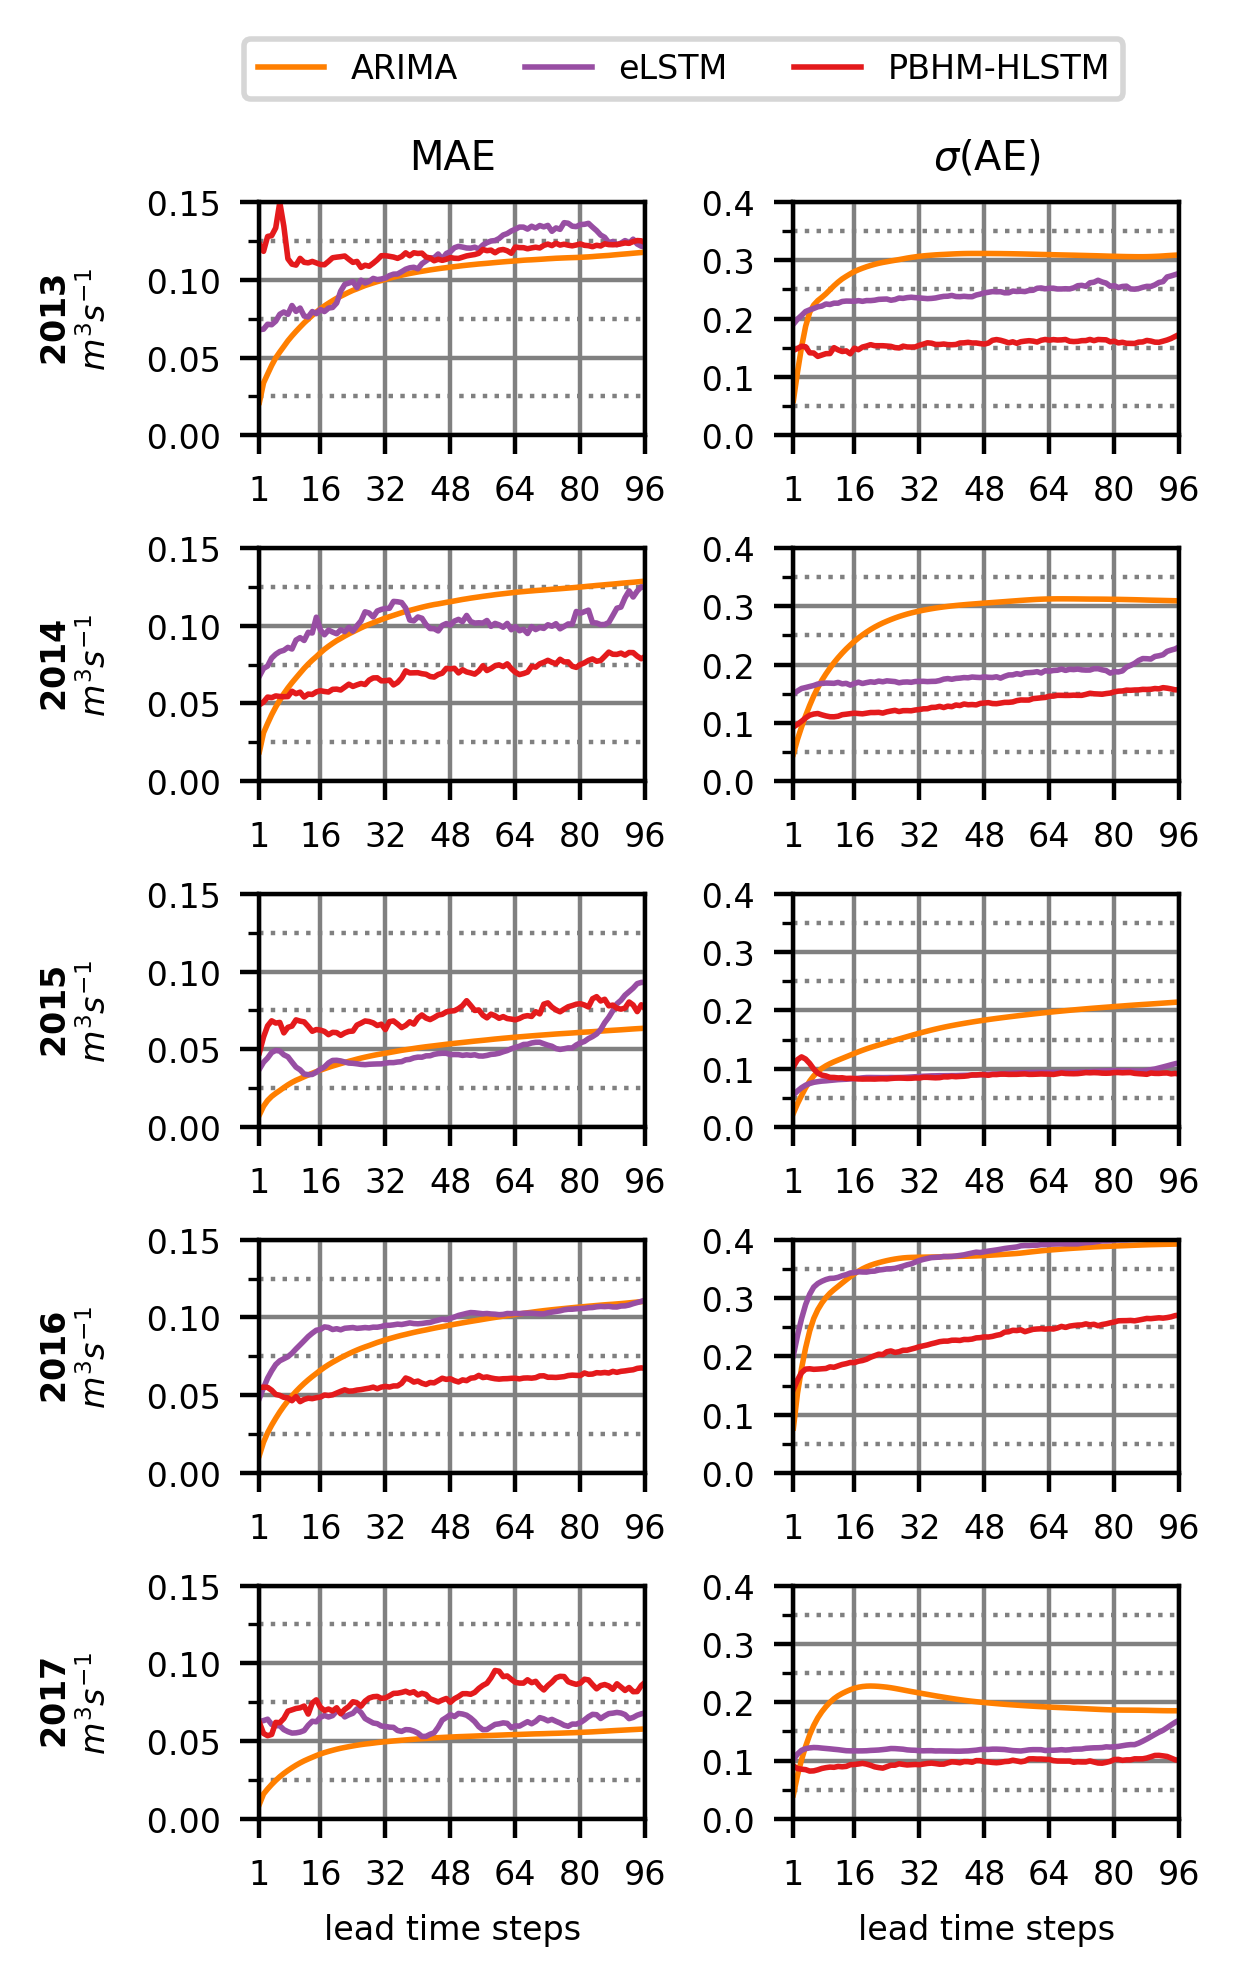

In [4]:
# initalize data frames for all flows
df = pd.DataFrame(index=pd.MultiIndex(levels=[[],[],np.arange(96)], 
                                      codes=[[],[],[]], 
                                      names=["model", "fold", "leadtime"],
                                     ),
                  columns = ["ae_mean", "ae_std"],
                 )

fig, axes = plt.subplots(5,2,figsize=(4.72*8.3/12,5), dpi=400)
for j, key in enumerate(models.keys()):   
    if models[key].is_external_model:
        overlap_length = 0
        hindcast_length = 96
    else:
        # load datamodel
        dm = DataModelCV(DATA_PATH,
           target_name       = models[key].target_name,
           hincast_features  = models[key].feat_hindcast,
           forecast_features = models[key].feat_forecast,
         )
        
        # load trial data
        with open(os.path.join(models[key].hp_path, "trial.json")) as f:
            trial = json.load(f)

        hindcast_length = trial['hyperparameters']['values']['hindcast_length']
        try:
            overlap_length = trial['hyperparameters']['values']['osc_length']
        except:
            overlap_length = 0 
        
        dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))
    
    for n_fold in range(5):
        year = 2013 + n_fold
        if models[key].is_external_model:
            # load external which come already with observations
            ext_df = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl"))

            # get external model observations
            y = np.expand_dims(ext_df.filter(like="obs").values, axis=2) # fix 

            # get external model predictions
            yp = ext_df.filter(like="fc").values
                        
        else:
            # load dataset
            X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 
            
            if os.path.exists(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")):
                yp = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl")).values
            else:
                # load model and predict
                tf.keras.backend.clear_session()
                model  = tf.keras.models.load_model(os.path.join(models[key].hp_path, f"model_fold_{n_fold:d}.keras"))                          

                # model prediction
                yp = model.predict(X, batch_size=1000)

        y = y[:,:,0]
        ae = np.abs(y-yp)
        ae_mean = np.mean(ae, axis=0)
        ae_std  = np.std(ae, axis=0)

        for n in range(len(ae_mean)):
            df.loc[(key, year, n)] = [ae_mean[n], ae_std[n]]
        
        
        x = np.arange(1,len(ae_mean)+1)
        axes[n_fold, 0].plot(x,ae_mean, color=models[key].color, lw=1, label=models[key].name)
        axes[n_fold, 1].plot(x,ae_std, color=models[key].color, lw=1)

        for j in range(2):
            axes[n_fold,j].set_xticks(np.array([1,16,32,48,64,80,96]))
            axes[n_fold,j].set_xlim(1, 96)
                
            
            axes[n_fold,j].grid(which='major', color='grey', linestyle='-')
            axes[n_fold,j].grid(which='minor', color='grey', linestyle=':')
            
            if j == 0:
                axes[n_fold,j].set_ylabel(r"$\bf{"+f"{2013 + n_fold}"+r"}$" +"\n$m^3s^{-1}$")
                axes[n_fold,j].set_ylim([0,0.15])
                axes[n_fold,j].yaxis.set_major_locator(MultipleLocator(0.05))
                axes[n_fold,j].yaxis.set_minor_locator(MultipleLocator(0.025))
                axes[n_fold,j].yaxis.set_major_formatter('{x: 4.2f}')
            elif j == 1:
                axes[n_fold,j].set_ylim([0,0.4])
                axes[n_fold,j].yaxis.set_major_locator(MultipleLocator(0.1))
                axes[n_fold,j].yaxis.set_minor_locator(MultipleLocator(0.05))
                axes[n_fold,j].yaxis.set_major_formatter('{x: 4.1f}')
                
            if n_fold == 0:
                axes[n_fold,0].set_title("MAE")
                axes[n_fold,1].set_title("$\sigma$(AE)")
            elif n_fold == 4:
                axes[n_fold,j].set_xlabel('lead time steps')

plt.tight_layout()
plt.subplots_adjust(top=0.89, right=0.9)
axes[0,0].legend(bbox_to_anchor=(1.1, 1.3),
                  loc='lower center', ncol=3, 
                  borderaxespad=1)

In [5]:
fig.savefig(os.path.join(PLOT_PATH, 'fig6_MAE_all_flows.png'), bbox_inches="tight", dpi=300)

## get ranking of model forecast stability -  all flows

In [6]:
# initalize
df["mean_rank"] = -1
df["std_rank"]  = -1

# ranking per leadtimestep and fold year 
for lts in range(96):
    for fold in range(2013,2018):
        ranking_mean = np.argsort(df.xs(fold, level=1).xs(lts, level=1)["ae_mean"]).argsort()
        for model in ranking_mean.index:
            df.loc[(model, fold, lts), "mean_rank"] = ranking_mean.loc[model]
        
        ranking_mean = np.argsort(df.xs(lts, level=2).xs(fold, level=1)["ae_std"]).argsort()
        for model in ranking_mean.index:
            df.loc[(model, fold, lts), "std_rank"] = ranking_mean.loc[model]

# achieved ranks per model and fold year
df_res = pd.DataFrame(index=[0,1,2])
df_res.index.name = "rank"

for fold in range(2013,2018):
    for model in df.index.get_level_values(0).unique():
        df_res[model+"_mean_"+str(fold)] = df["mean_rank"].xs(model, level=0).xs(fold, level=0).value_counts()
        df_res[model+"_std_"+str(fold)]  = df["std_rank"].xs(model, level=0).xs(fold, level=0).value_counts()
df_res = df_res.fillna(0) / 96 # make percentage

# get results into shape
names, stats, folds = zip(*[col.split('_') for col in df_res.columns])
names_stats = ["_".join([x,y]) for x,y in zip(names, stats)]
df_res.columns = pd.MultiIndex.from_arrays([names_stats, folds], names=['model_stat', 'fold'])
df_res = df_res.stack(level='fold').sort_index()

df_res

model_stat  arima_mean  arima_std  elstm_mean  elstm_std  pbhm-hlstm_mean  \
rank fold                                                                   
0    2013     0.937500   0.031250    0.062500   0.000000         0.000000   
     2014     0.062500   0.031250    0.000000   0.000000         0.937500   
     2015     0.333333   0.041667    0.666667   0.145833         0.000000   
     2016     0.083333   0.020833    0.000000   0.000000         0.916667   
     2017     1.000000   0.020833    0.000000   0.000000         0.000000   
1    2013     0.062500   0.020833    0.416667   0.947917         0.520833   
     2014     0.322917   0.041667    0.614583   0.927083         0.062500   
     2015     0.666667   0.020833    0.250000   0.854167         0.083333   
     2016     0.625000   0.760417    0.312500   0.218750         0.062500   
     2017     0.000000   0.010417    0.947917   0.968750         0.052083   
2    2013     0.000000   0.947917    0.520833   0.052083         0.479167   
     2014     0.614583   0.927083    0.385417   0.072917         0.000000   
     2015     0.000000   0.937500    0.083333   0.000000         0.916667   
     2016     0.291667   0.218750    0.687500   0.781250         0.020833   
     2017     0.000000   0.968750    0.052083   0.031250         0.947917   

model_stat  pbhm-hlstm_std  
rank fold                   
0    2013         0.968750  
     2014         0.968750  
     2015         0.812500  
     2016         0.979167  
     2017         0.979167  
1    2013         0.031250  
     2014         0.031250  
     2015         0.125000  
     2016         0.020833  
     2017         0.020833  
2    2013         0.000000  
     2014         0.000000  
     2015         0.062500  
     2016         0.000000  
     2017         0.000000

In [7]:
# average over all folds
df_res.groupby(level=0).mean()

model_stat,arima_mean,arima_std,elstm_mean,elstm_std,pbhm-hlstm_mean,pbhm-hlstm_std
rank,,,,,,
0,0.483333,0.029167,0.145833,0.029167,0.370833,0.941667
1,0.335417,0.170833,0.508333,0.783333,0.156250,0.045833
2,0.181250,0.800000,0.345833,0.187500,0.472917,0.012500


In [8]:
# find first lead time step arima loses 1st rank for std(AE)
print("ARIMA loses first rank in std(EA)")
for year in range(2013, 2018):
    ts_arima_lost_rank_0 = np.argmax(((df.xs(("arima", year))["std_rank"] == 0).cumsum()-1) != np.arange(96))
    print(f"  {year}: after {ts_arima_lost_rank_0} timesteps")

# find first lead time step arima loses 1st rank for mean(AE)
print("ARIMA loses first rank in mean(EA)")
for year in range(2013, 2018):
    ts_arima_lost_rank_0 = np.argmax(((df.xs(("arima", year))["mean_rank"] == 0).cumsum()-1) != np.arange(96))
    print(f"  {year}: after {ts_arima_lost_rank_0} timesteps")

ARIMA loses first rank in std(EA)
  2013: after 3 timesteps
  2014: after 3 timesteps
  2015: after 4 timesteps
  2016: after 2 timesteps
  2017: after 2 timesteps
ARIMA loses first rank in mean(EA)
  2013: after 14 timesteps
  2014: after 6 timesteps
  2015: after 13 timesteps
  2016: after 8 timesteps
  2017: after 0 timesteps
